# **Lab 8.1 Transfer Learning & Multitask Learning**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset,random_split
from PIL import Image


import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# #auto invert เจอ BG ดำให้ invert ให้หมด
# import cv2
# import os
# import numpy as np

# # Directory containing the images

# folder_names = ['eng-handwritten-dataset','thai-handwritten-dataset']
# for index,folder_name in enumerate(folder_names):
#     for i in range(10):
#         image_dir = f'data/data/{folder_names[index]}/{i}'
#         # print(image_dir)
#         # Iterate through all files in the directory
#         for filename in os.listdir(image_dir):
#             if filename.endswith(".jpg") or filename.endswith(".png"):
#                 file_path = os.path.join(image_dir, filename)
                
#                 # Read the image in grayscale
#                 img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                
#                 # Check the pixel at the top-left corner (0, 0)
#                 if img[0, 0] == 0:  # Assuming 0 represents black
#                     # Invert the image
#                     img_inverted = cv2.bitwise_not(img)
                    
#                     # Save the inverted image, overwriting the original file
#                     cv2.imwrite(file_path, img_inverted)
#                     # print(f"Inverted {filename}")
#                 else:
#                     pass
#                     # print(f"No need to invert {filename}")

#         # print("Processing complete.")


Complete the `MultiLanguageHandwrittenDataset` class below. It should return:
- `image`: the image data
- `label`: the digit label (0-9)
- `language`: the language (Thai or English)


In [3]:
### START CODE HERE ###
class MultiLanguageHandwrittenDataset(Dataset):
    def __init__(self, root_dirs, languages, transforms=None):
        self.root_dirs = root_dirs
        self.languages = languages
        self.transform = transforms
        self.samples = []
        for root_dir, language in zip(self.root_dirs, self.languages):
            for subdir in os.scandir(root_dir):
                if subdir.is_dir():
                    label = int(subdir.name)
                    for file in os.scandir(subdir.path):
                        if file.is_file():
                            self.samples.append((file.path, label, language))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label, language = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label, language
### END CODE HERE ###

use you `MultiLanguageHandwrittenDataset` here and display the first batch
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

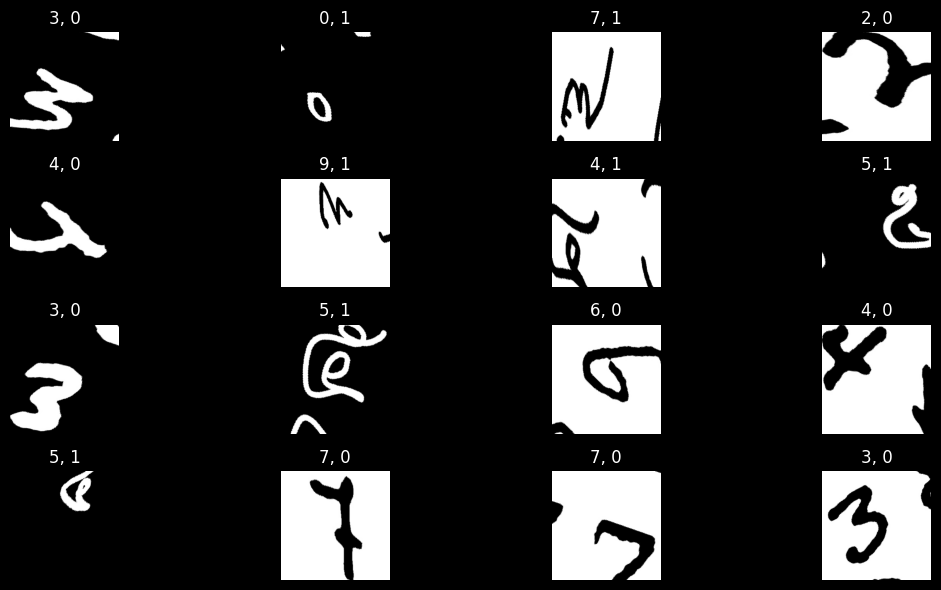

</details>

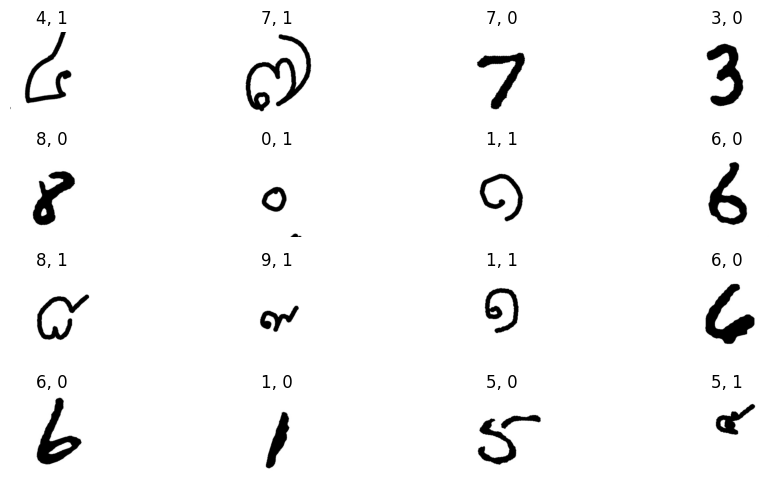

In [4]:
### START CODE HERE ###
def imshow_grid(images, labels, languages):
    fig = plt.figure(figsize=(10, 5))
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    for i in range(num_images):
        a = fig.add_subplot(grid_size, grid_size, i + 1)
        img = images[i]
        img = np.transpose(img, (1, 2, 0))  # Reformat image for display
        img = np.clip(img, 0, 1)  # Ensure pixel values are between 0 and 1
        
        # Display the image
        plt.imshow(img, cmap="Grays")
        a.axis("off")
        
        # Set the title to show both label and language
        plt.title(f"{labels[i].item()}, {languages[i]}")
    
    plt.tight_layout()
    plt.show()


root_dirs = ['data/data/eng-handwritten-dataset', 'data/data/thai-handwritten-dataset']
languages = ['0', '1'] #0 คือ Arabic 1 คือ Thai

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),   # Resize to 28x28
    transforms.Pad(padding=224,padding_mode='reflect'),
    transforms.RandomRotation(30),
    transforms.CenterCrop(224), #เอาออก 32x32 อิงตาม Architecture ของ Lenet
    transforms.ToTensor(),         # Convert to tensor
    
])

dataset = MultiLanguageHandwrittenDataset(root_dirs, languages, transforms=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

images, labels, language = next(iter(dataloader))
imshow_grid(images,labels,language)
# for images, labels, languages in dataloader:
#     print(f"Images shape: {images.shape}, Labels: {labels}, Languages: {languages}")
### END CODE HERE ###


## Transfer learning

Complete the `customVGG16` class below, which can create a pretrained VGG16 model and customize the number of fully connected (FC) layers. It also allows adding new convolutional layers and unfreezing pretrained layers based on their index.

In [5]:
### START CODE HERE ###
class customVGG16(nn.Module):
    def __init__(self, add_feat_dims=None, h_dims=None, num_classes=10, input_size=(1,28,28), trainable_layers_idx=None):
        super(customVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        
        # Freeze all layers by default
        for param in self.vgg16.parameters():
            param.requires_grad = False
        
        # Unfreeze specified layers
        if trainable_layers_idx is not None:
            for idx in trainable_layers_idx:
                for param in self.vgg16.features[idx].parameters():
                    param.requires_grad = True
        
        # Add new convolutional layers if specified
        if add_feat_dims:
            for dim in add_feat_dims:
                self.vgg16.features.append(nn.Conv2d(512, dim, kernel_size=3, padding=1))
                self.vgg16.features.append(nn.ReLU(inplace=True))
        
        # Modify the classifier
        input_size_fc = self._get_input_size_fc(input_size)
        classifier_layers = []
        prev_dim = input_size_fc
        
        if h_dims:
            for dim in h_dims:
                classifier_layers.extend([
                    nn.Linear(prev_dim, dim),
                    nn.ReLU(),
                    nn.Dropout(0.5)
                ])
                prev_dim = dim
        
        classifier_layers.append(nn.Linear(prev_dim, num_classes))
        self.vgg16.classifier = nn.Sequential(*classifier_layers)

    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.vgg16.features(x)
            x = self.vgg16.avgpool(x)
            x = torch.flatten(x, 1)
            return x.size(1)
    
    def forward(self, x):
        return self.vgg16(x)
### END CODE HERE ###


Example usage
```
trainable_layers_idx = [-1,-2,-3,-4,-5]
model = customVGG16(add_feat_dims=[512],h_dims=[512,256,256],input_size=(3,224,224),trainable_layers_idx=trainable_layers_idx)

```


Complete the `train` function below, which logs Loss/train, Accuracy/train, Loss/test, and Accuracy/test to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).Then, complete the evaluate_task function, which prints the classification report and plots the confusion matrix

In [20]:
### START CODE HERE ###
# Training function with TensorBoard logging
def train(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu', task='digit'):
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for batch_idx, (img, label, lang) in enumerate(train_loader):
            img, label, lang = img.to(device), label.to(device), torch.tensor(lang).to(device)
            if task == 'digit':
                opt.zero_grad()
                output = model(img)
                loss = loss_fn(output, label)
                loss.backward()
                opt.step()
                train_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                train_correct += pred.eq(label.view_as(pred)).sum().item()
            elif task == 'lang':
                opt.zero_grad()
                output = model(img)
                loss = loss_fn(output, lang)
                loss.backward()
                opt.step()
                train_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                train_correct += pred.eq(lang.view_as(pred)).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        
        val_loss, val_acc = evaluate(model, loss_fn, val_loader, device, task=task)
        
        if writer:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Accuracy/train', train_acc, epoch)
            writer.add_scalar('Loss/val', val_loss, epoch)
            writer.add_scalar('Accuracy/val', val_acc, epoch)
        
        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if checkpoint_path:
                torch.save(model.state_dict(), checkpoint_path)
    
    return model

def evaluate(model, loss_fn, data_loader, device, task='digit'):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        if task == 'digit':
            for img, label, lang in data_loader:
                img, label = img.to(device), label.to(device)
                output = model(img)
                loss += loss_fn(output, label).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(label.view_as(pred)).sum().item()
        elif task == 'lang':
            for img, label, lang  in data_loader:
                img, lang = img.to(device),torch.tensor(lang).to(device)
                output = model(img)
                loss += loss_fn(output, lang).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(lang.view_as(pred)).sum().item()
    loss /= len(data_loader.dataset)
    accuracy = correct / len(data_loader.dataset)
    return loss, accuracy

def evaluate_task(y_true, y_pred, task_name="Task"):
    print(f"\n{task_name}: Classification Report")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{task_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
### END CODE HERE ###


### Transfer learning for Digit classification task
Declare the `customVGG16` model with custom layers of your choice. Then, split the dataset into training, validation, and test sets, and proceed to train the model.

In [8]:
### START CODE HERE ###
# Set up the model
trainable_layers_idx = [-1, -2, -3, -4, -5]
model1 = customVGG16(add_feat_dims=[512], h_dims=[512, 256, 256], input_size=(3, 224, 224), trainable_layers_idx=trainable_layers_idx, num_classes=10)

# Set up the datasets
root_dirs = ['data/data/eng-handwritten-dataset', 'data/data/thai-handwritten-dataset']
languages = [0, 1]

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_dataset = MultiLanguageHandwrittenDataset(root_dirs, languages, transforms=transform)

# Split the dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)
opt = optim.Adam(model1.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Set up TensorBoard
writer = SummaryWriter('runs/digit_classification')

# Train the model
train(model1, opt, loss_fn, train_loader, val_loader, epochs=10, writer=writer, checkpoint_path='digit_classification.pth', device=device, task='digit')
### END CODE HERE ###



c:\Users\sitth\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sitth\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


use `evaluate_task` to evlauate you model1 here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Digit - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.75      0.94      0.83        32
           2       0.66      0.54      0.59        39
           3       0.76      0.54      0.63        35
           4       0.68      0.53      0.60        47
           5       0.52      0.42      0.47        33
           6       0.59      0.88      0.71        33
           7       0.46      0.59      0.52        27
           8       0.70      0.65      0.67        43
           9       0.85      0.83      0.84        35

    accuracy                           0.67       350
   macro avg       0.67      0.68      0.67       350
weighted avg       0.68      0.67      0.67       350

```

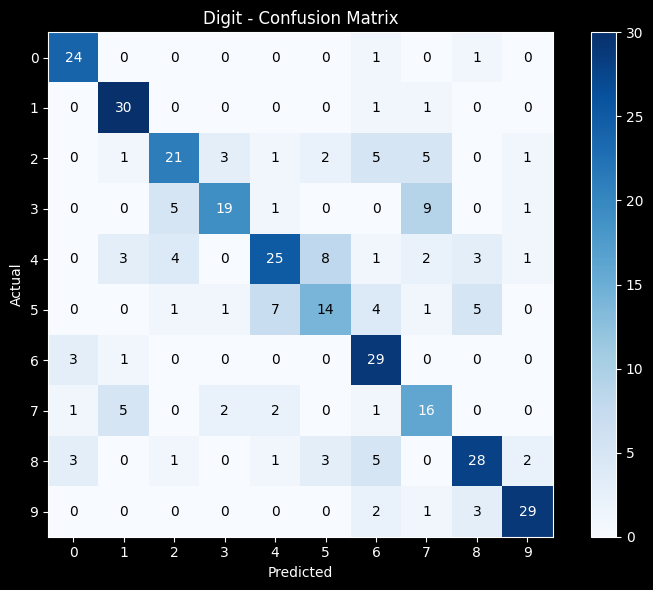

</details>

C:\Users\sitth\AppData\Local\Temp\ipykernel_7340\931644055.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('digit_classification.pth'))

Test Loss: 0.0026, Test Accuracy: 0.9772

Digit: Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        61
           1       0.92      0.98      0.95        46
           2       1.00      0.95      0.97        39
           3       1.00      0.96      0.98        55
           4       1.00      0.96      0.98        52
           5       0.96      0.98      0.97        48
           6       0.98      0.98      0.98        49
           7       0.98      0.98      0.98        66
           8       0.98      1.00      0.99        53
           9       0.98      0.98      0.98        57

    accuracy                           0.98       526
   macro avg       0.98      0.98      0.98       526
weighted avg       0.98      0.98      0.98       526



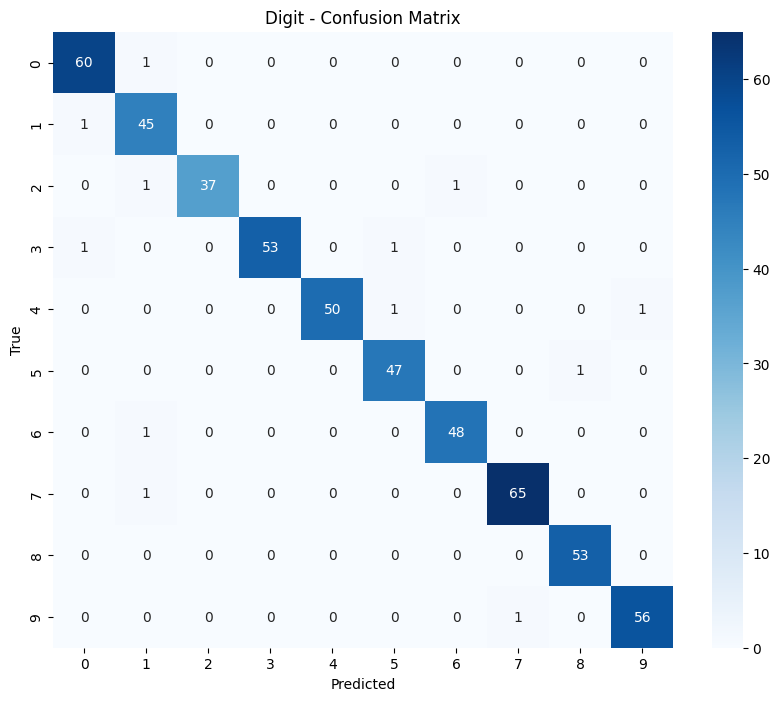

In [21]:
### START CODE HERE ###
# Evaluate on test set
model1.load_state_dict(torch.load('digit_classification.pth'))
test_loss, test_acc = evaluate(model1, loss_fn, test_loader, device, task='digit')
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Get predictions for the entire test set
y_true = []
y_pred = []
model1.eval()
with torch.no_grad():
    for data, target, _ in test_loader:
        data, target = data.to(device), target.to(device)
        output = model1(data)
        pred = output.argmax(dim=1, keepdim=True)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
evaluate_task(y_true, y_pred, task_name="Digit")
### END CODE HERE ###


### Transfer learning for Language classification task
Declare a NEW `customVGG16` model with custom layers of your choice.

In [10]:
### START CODE HERE ###
model2 = customVGG16(add_feat_dims=[256], h_dims=[256, 128], input_size=(3, 224, 224), trainable_layers_idx=[-1, -2, -3], num_classes=2)

root_dirs = ['data/data/eng-handwritten-dataset', 'data/data/thai-handwritten-dataset']
languages = [0, 1]

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_dataset = MultiLanguageHandwrittenDataset(root_dirs, languages, transforms=transform)

# Split the dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)
opt = optim.Adam(model2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Set up TensorBoard
writer = SummaryWriter('runs/language_classification')

# Train the model
train(model2, opt, loss_fn, train_loader, val_loader, epochs=10, writer=writer, checkpoint_path='lang_classification.pth', device=device, task='lang')
### END CODE HERE ###


c:\Users\sitth\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sitth\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


use `evaluate_task` to evlauate you model2 here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Language - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       175
           1       0.99      0.93      0.96       175

    accuracy                           0.96       350
   macro avg       0.96      0.96      0.96       350
weighted avg       0.96      0.96      0.96       350

```

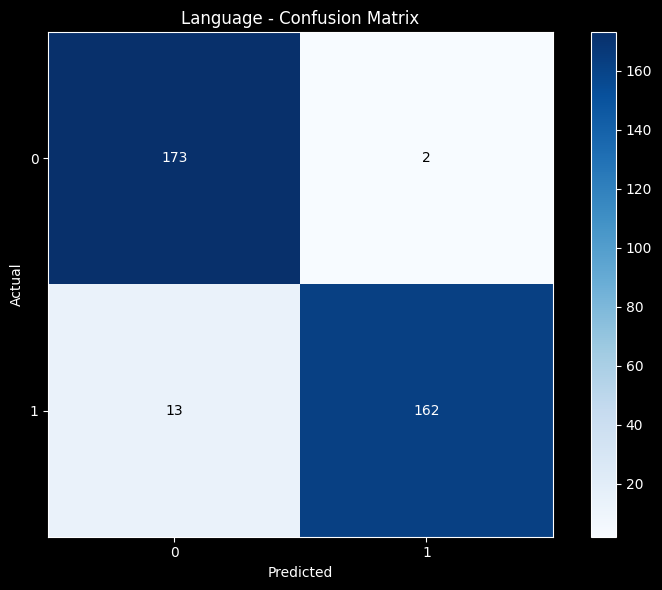

</details>

C:\Users\sitth\AppData\Local\Temp\ipykernel_7340\1522986988.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('lang_classification.pth'))

Test Loss: 0.0001, Test Accuracy: 1.0000

Language: Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       265
           1       1.00      1.00      1.00       261

    accuracy                           1.00       526
   macro avg       1.00      1.00      1.00       526
weighted avg       1.00      1.00      1.00       526



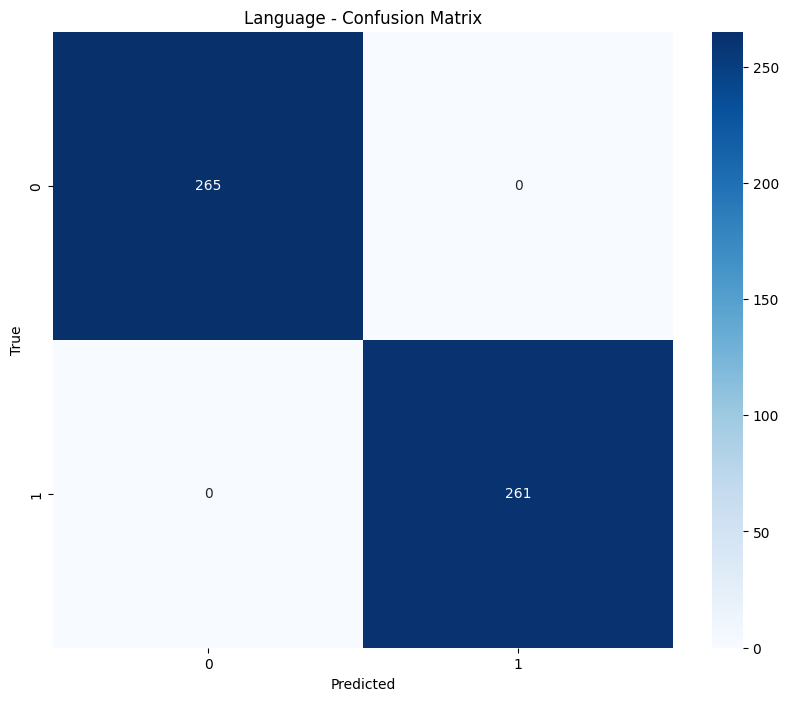

In [22]:
### START CODE HERE ###
# Evaluate on test set
model2.load_state_dict(torch.load('lang_classification.pth'))
test_loss, test_acc = evaluate(model2, loss_fn, test_loader, device, task='lang')
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Get predictions for the entire test set
y_true = []
y_pred = []
model2.eval()
with torch.no_grad():
    for data, target, lang in test_loader:
        data, lang = data.to(device), lang.to(device)
        output = model2(data)
        pred = output.argmax(dim=1, keepdim=True)
        y_true.extend(lang.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
evaluate_task(y_true, y_pred, task_name="Language")
### END CODE HERE ###

---

## Multitask learning

Complete the `customVGG16_multitask` class below, which can create a pretrained VGG16 model and customize the number of fully connected (FC) layers. It also allows adding new convolutional layers and unfreezing pretrained layers based on their index. Additionally, it allows branching the model into two heads for multitask learning, where one head handles digit classification, and the other handles language classification

In [27]:
class customVGG16_multitask(nn.Module):
    def __init__(self, add_feat_dims=None, h_dims=None, input_size=(1,28,28), trainable_layers_idx=None):
        super(customVGG16_multitask, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        
        # Freeze all layers by default
        for param in self.vgg16.parameters():
            param.requires_grad = False
        
        # Unfreeze specified layers
        if trainable_layers_idx is not None:
            for idx in trainable_layers_idx:
                for param in self.vgg16.features[idx].parameters():
                    param.requires_grad = True
        
        # Add new convolutional layers if specified
        if add_feat_dims:
            for dim in add_feat_dims:
                self.vgg16.features.append(nn.Conv2d(512, dim, kernel_size=3, padding=1))
                self.vgg16.features.append(nn.ReLU(inplace=True))
        
        # Modify the classifier for multitask learning
        input_size_fc = self._get_input_size_fc(input_size)
        
        # Digit classification head
        self.vgg16.digit = self._create_classifier(input_size_fc, h_dims, 10)
        
        # Language classification head
        self.vgg16.lang = self._create_classifier(input_size_fc, h_dims, 2)

    def _create_classifier(self, input_size, h_dims, num_classes):
        layers = []
        prev_dim = input_size
        
        if h_dims:
            for dim in h_dims:
                layers.extend([
                    nn.Linear(prev_dim, dim),
                    nn.ReLU(),
                    nn.Dropout(0.5)
                ])
                prev_dim = dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        return nn.Sequential(*layers)

    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.vgg16.features(x)
            x = self.vgg16.avgpool(x)
            x = torch.flatten(x, 1)
            return x.size(1)
    
    def forward(self, x):
        features = self.vgg16.features(x)
        features = self.vgg16.avgpool(features)
        features = torch.flatten(features, 1)
        out1 = self.vgg16.digit(features)
        out2 = self.vgg16.lang(features)
        return out1, out2

Complete the `train_multi` function below, which train multitask model and  logs Loss/train, Accuracy/train, Loss/test, and Accuracy/test to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).

In [28]:
def train_multi(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct_digit, train_correct_lang = 0, 0, 0
        for batch_idx, (img, label, lang) in enumerate(train_loader):
            img, label, lang = img.to(device), label.to(device), lang.to(device)
            opt.zero_grad()
            digit_output, lang_output = model(img)
            loss_digit = loss_fn(digit_output, label)
            loss_lang = loss_fn(lang_output, lang)
            loss = loss_digit + loss_lang
            loss.backward()
            opt.step()
            train_loss += loss.item()
            pred_digit = digit_output.argmax(dim=1, keepdim=True)
            pred_lang = lang_output.argmax(dim=1, keepdim=True)
            train_correct_digit += pred_digit.eq(label.view_as(pred_digit)).sum().item()
            train_correct_lang += pred_lang.eq(lang.view_as(pred_lang)).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_acc_digit = train_correct_digit / len(train_loader.dataset)
        train_acc_lang = train_correct_lang / len(train_loader.dataset)
        
        val_loss, val_acc_digit, val_acc_lang = evaluate_multi(model, loss_fn, val_loader, device)
        
        if writer:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Accuracy/train/digit', train_acc_digit, epoch)
            writer.add_scalar('Accuracy/train/lang', train_acc_lang, epoch)
            writer.add_scalar('Loss/val', val_loss, epoch)
            writer.add_scalar('Accuracy/val/digit', val_acc_digit, epoch)
            writer.add_scalar('Accuracy/val/lang', val_acc_lang, epoch)
        
        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, '
              f'Train Acc Digit: {train_acc_digit:.4f}, Train Acc Lang: {train_acc_lang:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc Digit: {val_acc_digit:.4f}, Val Acc Lang: {val_acc_lang:.4f}')
        
        if (val_acc_digit + val_acc_lang) / 2 > best_val_acc:
            best_val_acc = (val_acc_digit + val_acc_lang) / 2
            if checkpoint_path:
                torch.save(model.state_dict(), checkpoint_path)
    
    return model

def evaluate_multi(model, loss_fn, data_loader, device):
    model.eval()
    loss = 0
    correct_digit = 0
    correct_lang = 0
    with torch.no_grad():
        for img, label, lang in data_loader:
            img, label, lang = img.to(device), label.to(device), lang.to(device)
            digit_output, lang_output = model(img)
            loss += (loss_fn(digit_output, label) + loss_fn(lang_output, lang)).item()
            pred_digit = digit_output.argmax(dim=1, keepdim=True)
            pred_lang = lang_output.argmax(dim=1, keepdim=True)
            correct_digit += pred_digit.eq(label.view_as(pred_digit)).sum().item()
            correct_lang += pred_lang.eq(lang.view_as(pred_lang)).sum().item()
    loss /= len(data_loader.dataset)
    accuracy_digit = correct_digit / len(data_loader.dataset)
    accuracy_lang = correct_lang / len(data_loader.dataset)
    return loss, accuracy_digit, accuracy_lang

In [29]:
### START CODE HERE ###
# Set up the datasets
root_dirs = ['data/data/eng-handwritten-dataset', 'data/data/thai-handwritten-dataset']
languages = [0, 1]

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_dataset = MultiLanguageHandwrittenDataset(root_dirs, languages, transforms=transform)

# Split the dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set up the model
trainable_layers_idx = [-1, -2, -3, -4, -5]
model = customVGG16_multitask(add_feat_dims=[512], h_dims=[512, 256], input_size=(3, 224, 224), trainable_layers_idx=trainable_layers_idx)

# Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Set up TensorBoard
writer = SummaryWriter('runs/multitask_classification')

# Train the model
train_multi(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=writer, checkpoint_path='multitask_classification.pth', device=device)

### END CODE HERE ###


Epoch 1/10: Train Loss: 0.0527, Train Acc Digit: 0.4352, Train Acc Lang: 0.9743, Val Loss: 0.0180, Val Acc Digit: 0.8130, Val Acc Lang: 0.9962
Epoch 2/10: Train Loss: 0.0205, Train Acc Digit: 0.8092, Train Acc Lang: 0.9914, Val Loss: 0.0101, Val Acc Digit: 0.9008, Val Acc Lang: 0.9981
Epoch 3/10: Train Loss: 0.0115, Train Acc Digit: 0.8913, Train Acc Lang: 0.9951, Val Loss: 0.0081, Val Acc Digit: 0.9218, Val Acc Lang: 0.9981
Epoch 4/10: Train Loss: 0.0070, Train Acc Digit: 0.9367, Train Acc Lang: 0.9984, Val Loss: 0.0073, Val Acc Digit: 0.9294, Val Acc Lang: 0.9981
Epoch 5/10: Train Loss: 0.0066, Train Acc Digit: 0.9452, Train Acc Lang: 0.9992, Val Loss: 0.0091, Val Acc Digit: 0.9256, Val Acc Lang: 0.9924
Epoch 6/10: Train Loss: 0.0071, Train Acc Digit: 0.9424, Train Acc Lang: 0.9984, Val Loss: 0.0073, Val Acc Digit: 0.9351, Val Acc Lang: 1.0000
Epoch 7/10: Train Loss: 0.0059, Train Acc Digit: 0.9526, Train Acc Lang: 0.9988, Val Loss: 0.0072, Val Acc Digit: 0.9389, Val Acc Lang: 0.9981

customVGG16_multitask(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

use `evaluate_task` to evlauate you model here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Digit - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        35
           1       0.81      0.91      0.85        32
           2       0.76      0.55      0.64        40
           3       0.53      0.66      0.58        32
           4       0.54      0.29      0.38        24
           5       0.51      0.57      0.54        37
           6       0.68      0.72      0.70        29
           7       0.60      0.71      0.65        34
           8       0.62      0.71      0.66        48
           9       0.68      0.49      0.57        39

    accuracy                           0.65       350
   macro avg       0.66      0.65      0.64       350
weighted avg       0.66      0.65      0.65       350

```

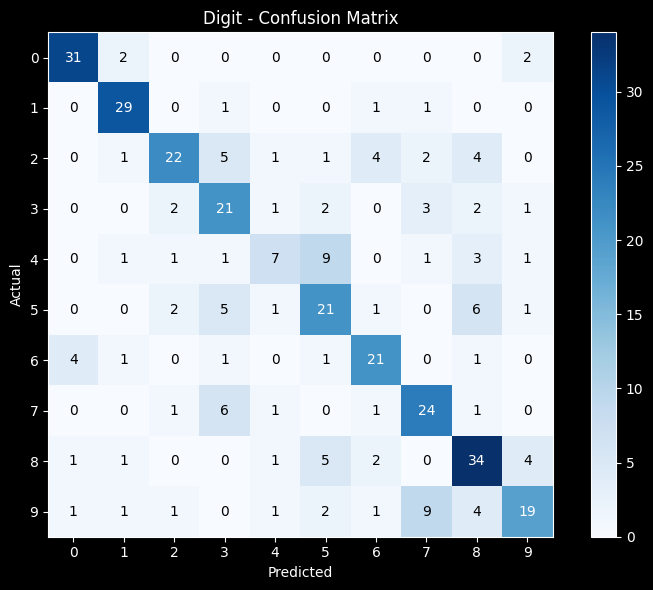

```
Language - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       172
           1       0.98      0.98      0.98       178

    accuracy                           0.98       350
   macro avg       0.98      0.98      0.98       350
weighted avg       0.98      0.98      0.98       350
```

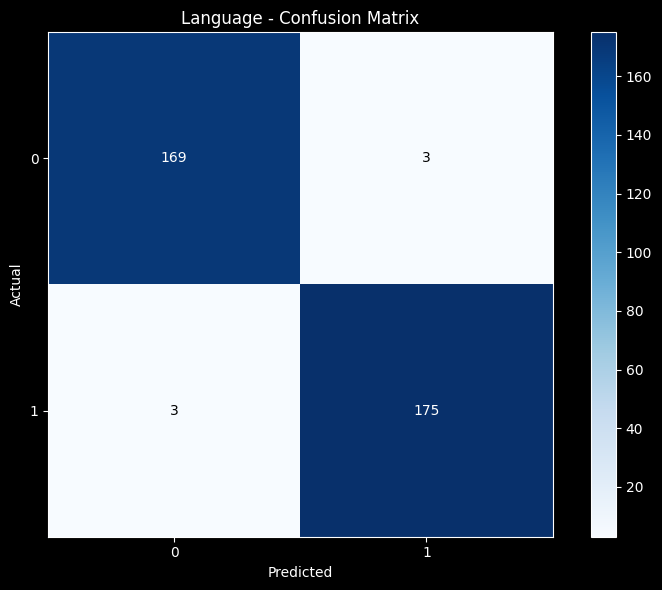

</details>

C:\Users\sitth\AppData\Local\Temp\ipykernel_7340\3550463205.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('multitask_classification.pt

Test Loss: 0.0110, Test Accuracy Digit: 0.9392, Test Accuracy Lang: 0.9962

Digit Classification: Classification Report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        52
           1       0.93      0.95      0.94        41
           2       0.98      0.93      0.96        46
           3       1.00      0.97      0.98        59
           4       0.85      0.96      0.91        55
           5       0.88      0.98      0.93        54
           6       0.92      0.88      0.90        56
           7       0.98      0.93      0.95        56
           8       1.00      0.92      0.96        48
           9       0.96      0.92      0.94        59

    accuracy                           0.94       526
   macro avg       0.94      0.94      0.94       526
weighted avg       0.94      0.94      0.94       526



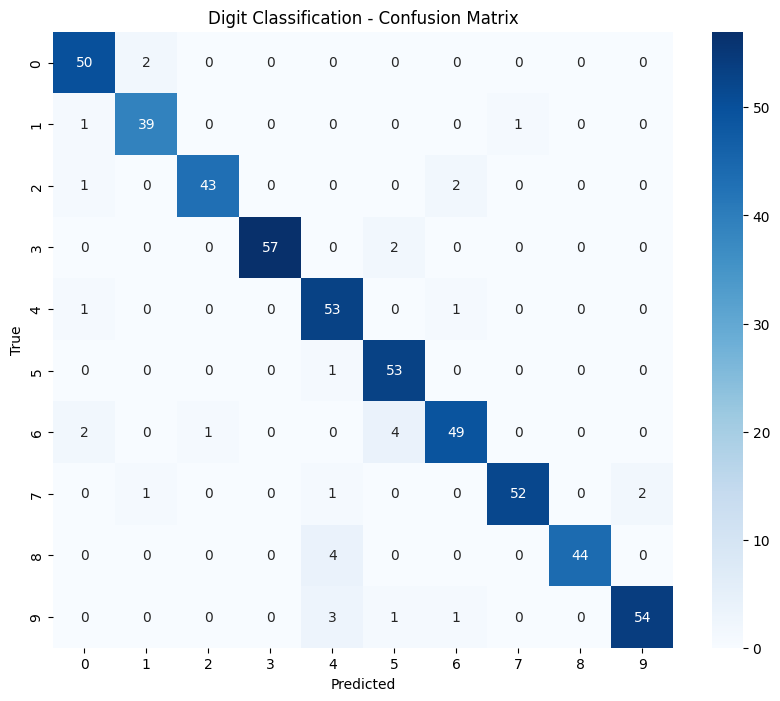


Language Classification: Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       257
           1       0.99      1.00      1.00       269

    accuracy                           1.00       526
   macro avg       1.00      1.00      1.00       526
weighted avg       1.00      1.00      1.00       526



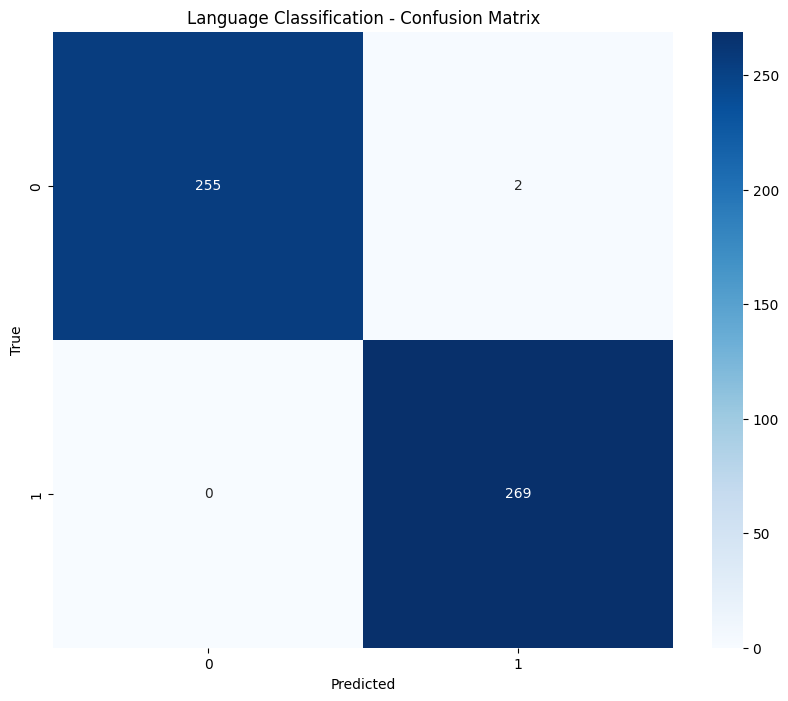

In [30]:
### START CODE HERE ###
# Evaluate on test set
model.load_state_dict(torch.load('multitask_classification.pth'))
test_loss, test_acc_digit, test_acc_lang = evaluate_multi(model, loss_fn, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy Digit: {test_acc_digit:.4f}, Test Accuracy Lang: {test_acc_lang:.4f}")

# Get predictions for the entire test set
y_true_digit = []
y_pred_digit = []
y_true_lang = []
y_pred_lang = []
model.eval()
with torch.no_grad():
    for data, target_digit, target_lang in test_loader:
        data, target_digit, target_lang = data.to(device), target_digit.to(device), target_lang.to(device)
        output_digit, output_lang = model(data)
        pred_digit = output_digit.argmax(dim=1, keepdim=True)
        pred_lang = output_lang.argmax(dim=1, keepdim=True)
        y_true_digit.extend(target_digit.cpu().numpy())
        y_pred_digit.extend(pred_digit.cpu().numpy())
        y_true_lang.extend(target_lang.cpu().numpy())
        y_pred_lang.extend(pred_lang.cpu().numpy())

# Evaluate tasks
evaluate_task(y_true_digit, y_pred_digit, task_name="Digit Classification")
evaluate_task(y_true_lang, y_pred_lang, task_name="Language Classification")
### END CODE HERE ###


---
# Question
1. If you build two separate models, one for each task with a different classification problem, 
how does the overall model size of two separate models compared to a single model with shared layers and two classifiers 
at the end?

2. In what scenarios might a single model with two classifiers outperform two separate models in terms of generalization? Is there a risk of one task negatively affecting the other?

3. How can weighted loss functions be applied in a single model with two classifiers to balance the performance of both tasks?

# ตอบคำถาม LAB 8.1
1. If you build two separate models, one for each task with a different classification problem, 
how does the overall model size of two separate models compared to a single model with shared layers and two classifiers 
at the end?

    ANS: 2 separate models มีขนาดเล็กกว่า 2 shared model 

2. In what scenarios might a single model with two classifiers outperform two separate models in terms of generalization? Is there a risk of one task negatively affecting the other?
    ANS: จะใช้เมื่อโจทย์ที่ทำสอดคล้องกับ model ที่มี เช่น ต้องการทราบตัวเลข และภาษาของตัวเลขพร้อมๆ กัน 
    อาจแย่หากขณะ learning process ถูกข่มโดยอีก classifiers นึง ทำให้ประสิทธิภาพในโจทย์อื่นๆ ไม่ดี

3. How can weighted loss functions be applied in a single model with two classifiers to balance the performance of both tasks?

    ANS: ใช้วิธี dynamic weighted ปรับ wdight อัตโนมัติระหว่างการ train